# Modélisation avancé



In [1]:
import pandas as pd
import numpy as np 

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

In [2]:
import spacy
from tensorboard.plugins.hparams import api as hp

In [3]:
dir_data = "./data/"
df_nlp = pd.read_csv(dir_data + "training.1600000.processed.noemoticon.csv",
                     encoding="ISO-8859-1",
                     header=None,
                     names=["target","id","date","flag","user","text"])

In [4]:
df_nlp.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df_nlp["sentiment"] = df_nlp["target"].apply(lambda x : "good" if x==4 else "bad").values

# Séparation jeu de données d'entrainement/test

In [6]:
from sklearn.model_selection import train_test_split

data_train,data_test = train_test_split(df_nlp,test_size=0.2,stratify=df_nlp["sentiment"],random_state=42)

In [7]:
data_train["sentiment"].value_counts()

good    640000
bad     640000
Name: sentiment, dtype: int64

In [8]:
X_train = data_train["text"].values
y_train = data_train["sentiment"].values

X_test = data_test["text"].values
y_test = data_test["sentiment"].values
print("train_set :",X_train.shape)
print("test_set :",X_test.shape)

train_set : (1280000,)
test_set : (320000,)


## Premier nettoyage des données

In [9]:
test_clean = "http://twitpic.com/2y1zl http://twitpic.com/2y1zl/ezfez489 https://twitpic.com/"
test_clean +=" http://192.168.1.1/test http://azure.microsoft.com/"
# remove url
print(test_clean)
def clean_url(sentence):
    sentence = re.sub('http[s]*://[0-9a-zA-Z-_.]*.[a-z]{0,3}/[0-9a-zA-Z-_./]*', '', sentence)
    return sentence

print("clean :", clean_url(test_clean))

http://twitpic.com/2y1zl http://twitpic.com/2y1zl/ezfez489 https://twitpic.com/ http://192.168.1.1/test http://azure.microsoft.com/
clean :     


In [10]:
# smile
test_clean = ";) xD xDDDDDD xP :D ;D ;d :) ^^ ^-^ :$ *-* :p ;p :o :S ;S :/ B)  ;( :( =) =D =$ =S =P =O :| =| ;| x) O_o o_O XO --\'"
# confusion, do not clean
test_clean += "\n\n:serpent xDeep :Departement :pertes :origan =Departement =pertes =Origan =$5 :$10"

# remove url
print(test_clean)
def clean_smile(sentence):
    sentence = re.sub(';\)','emote_clin_doeil ',sentence)
    sentence = re.sub(':\)|=\)','emote_sourire ',sentence)
    sentence = re.sub('x\)','emote_cross_smile ',sentence)
    sentence = re.sub('x{1,}[Dd]{1,}[^A-Za-z0-9]','emote_mdr ',sentence)
    sentence = re.sub(';[pP]{1,}[^A-Za-z0-9]|:[pP]{1,}[^A-Za-z0-9]|x[pP]{1,}[^A-Za-z0-9]|=[pP]{1,}[^A-Za-z0-9]',
                      'emote_tire_langue ',sentence)
    sentence = re.sub('[oO]_[oO]','emote_tres_surpris',sentence)
    sentence = re.sub('[Xx]{1,}[Oo]{1,}[^A-Za-z0-9]','emote_ko ',sentence)
    sentence = re.sub('[bB]\)[^A-Za-z0-9]','emote_lunette ',sentence)
    sentence = re.sub('[=:;][oO]{1,}[^A-Za-z0-9]','emote_surpris ',sentence)
    sentence = re.sub('[=:;][S]{1,}[^A-Za-z0-9]','emote_genant ',sentence)
    sentence = re.sub('[:;=][dD]{1,}[^A-Za-z0-9]','emote_gros_sourire ',sentence)
    sentence = re.sub('[:;=][$]{1,}[^A-Za-z0-9]','emote_genant_discret ',sentence)
    sentence = re.sub('[:;=]\|[^A-Za-z0-9]','emote_neutre ',sentence)
    sentence = re.sub('[:;=]/[^A-Za-z0-9]','emote_deception ',sentence)
    sentence = re.sub('[:;=]\([^A-Za-z0-9]','emote_insatisfait ',sentence)
    sentence = re.sub('\*[-_]\*[^A-Za-z0-9]','emote_magnifique ',sentence)
    sentence = re.sub('\^[-_]{0,1}\^[^A-Za-z0-9]','emote_joyeux ',sentence)
    sentence = re.sub('--\'[^A-Za-z0-9]','emote_enerve ',sentence)
    return sentence
print("-------------------------")
print("clean :",clean_smile(test_clean))

;) xD xDDDDDD xP :D ;D ;d :) ^^ ^-^ :$ *-* :p ;p :o :S ;S :/ B)  ;( :( =) =D =$ =S =P =O :| =| ;| x) O_o o_O XO --'

:serpent xDeep :Departement :pertes :origan =Departement =pertes =Origan =$5 :$10
-------------------------
clean : emote_clin_doeil  emote_mdr emote_mdr emote_tire_langue emote_gros_sourire emote_gros_sourire emote_gros_sourire emote_sourire  emote_joyeux emote_joyeux emote_genant_discret emote_magnifique emote_tire_langue emote_tire_langue emote_surpris emote_genant emote_genant emote_deception emote_lunette  emote_insatisfait emote_insatisfait emote_sourire  emote_gros_sourire emote_genant_discret emote_genant emote_tire_langue emote_surpris emote_neutre emote_neutre emote_neutre emote_cross_smile  emote_tres_surpris emote_tres_surpris emote_ko emote_enerve 
:serpent xDeep :Departement :pertes :origan =Departement =pertes =Origan =$5 :$10


In [11]:
test_clean = " jack &amp; martine say\" I love banana\" & &quot;And you&quot; &lt;a href=ettoutetout &gt;"
def clean_escape(sentence):
    sentence = re.sub('&amp;','&',sentence)
    sentence = re.sub('&quot;','\"',sentence)
    sentence = re.sub('&gt;','>',sentence)
    sentence = re.sub('&lt;','<',sentence)
    return sentence

print(test_clean)
print("--------------")
print("clean :",clean_escape(test_clean))

 jack &amp; martine say" I love banana" & &quot;And you&quot; &lt;a href=ettoutetout &gt;
--------------
clean :  jack & martine say" I love banana" & "And you" <a href=ettoutetout >


In [12]:
test_clean = "e same think p e lol it\'s fun 123 1 5 + 6 =11 aaaaaaaaa"
def clean_uniuque_char(sentence):
    sentence = " ".join([v for v in sentence.split(" ") if ((len(v) > 1) or (not v.isalpha()))])
    return sentence

print(test_clean)
print("--------------")
print("clean :",clean_uniuque_char(test_clean))

e same think p e lol it's fun 123 1 5 + 6 =11 aaaaaaaaa
--------------
clean : same think lol it's fun 123 1 5 + 6 =11 aaaaaaaaa


In [13]:
test_clean = X_train[489456]
print(test_clean)
def cleanning_data(sentence):
    sentence += " "
    sentence = re.sub('\n+', ' ', sentence.lower())
    # special caractère
    sentence = re.sub('[éèêë]','e',sentence)
    sentence = re.sub('[ïîì]','i',sentence)
    sentence = re.sub('[àâä]','a',sentence)
    sentence = re.sub('[ôö]','o',sentence) 
    sentence = re.sub('[üûù]','u',sentence)
    sentence = re.sub('[ç]','c',sentence)
    # personal_clean
    sentence = clean_escape(sentence) # usless ?
    sentence = clean_url(sentence)
    sentence = clean_smile(sentence)
    sentence = re.sub(r'[^a-z@#\'_ ]+',' ',sentence)
    sentence = clean_uniuque_char(sentence)
    sentence = re.sub(' {2,}', ' ', sentence)
    return sentence

print(cleanning_data(test_clean))

@AbbiDawson no but you only need to pay for plane tickets, you live with me  my mom thought it was a good idea ;)
@abbidawson no but you only need to pay for plane tickets you live with me my mom thought it was good idea emote_clin_doeil 


In [14]:
%%time
X_train = [cleanning_data(sentence) for sentence in X_train]

CPU times: user 50.2 s, sys: 175 ms, total: 50.4 s
Wall time: 50.4 s


In [71]:
print(X_train[0])

@paisleypaisley lol why do get ideas so far in advance it's not even june yet we need third knitter to have our own summer group 


## Stop_word /  lemmatization & stemming

In [14]:
nlp = spacy.load("en_core_web_sm",disable=["ner","parser"])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [15]:
sw = nlp.Defaults.stop_words

In [100]:
%%time
X_train = [" ".join([w.lemma_.lower() for w in doc if not w.text.lower() in sw]) for doc in nlp.pipe(X_train, batch_size=2000, n_process=70)]

CPU times: user 9min 19s, sys: 31 s, total: 9min 50s
Wall time: 9min 13s


In [80]:
print(X_train[489456])

@abbidawson need pay plane ticket live mom think good idea emote_clin_doeil


In [81]:
number = 189498
print(X_train[number])
print()
print(data_train["text"].iloc[number])

@stevehill refer drama work little act class job

@SteveHills &amp; if u were refering to the drama I was working on a little while back. It was for acting class not for a job. 


In [16]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
ps = PorterStemmer()

In [89]:
%%time
stemming_data = [" ".join([ps.stem(w) for w in nltk.word_tokenize(tweet) if not w in sw]) for tweet in X_train]

CPU times: user 4min 43s, sys: 0 ns, total: 4min 43s
Wall time: 4min 43s


In [95]:
stemming_data[4]

'stand know wo wo gone miss home'

## Création de fonction (clean, vectorisation/word embedding)

In [18]:
sw = nlp.Defaults.stop_words
def basic_clean(docs,stop_word=True,multithreading = False ,n_process=70,batch_size=2000,stemming=False):
    new_docs = [cleanning_data(sentence) for sentence in docs]
    if stemming:
        ps = PorterStemmer()
        if stop_word:
            return [" ".join([ps.stem(w) for w in nltk.word_tokenize(tweet) if not w in sw]) for tweet in docs]
        else:
            return [" ".join([ps.stem(w) for w in nltk.word_tokenize(tweet)]) for tweet in docs]
    else:
        if multithreading:
            if stop_word:
                return [" ".join([w.lemma_.lower() for w in doc if not w.text.lower() in sw]) for doc in nlp.pipe(new_docs, batch_size=batch_size, n_process=n_process)]
            else:
                return [" ".join([w.lemma_.lower() for w in doc]) for doc in nlp.pipe(new_docs, batch_size=batch_size, n_process=n_process)]
        else:
            if stop_word:
                return [" ".join([w.lemma_.lower() for w in nlp(doc) if not w.text.lower() in sw]) for doc in new_docs]
            else:
                return [" ".join([w.lemma_.lower() for w in nlp(doc)]) for doc in new_docs]
    

In [104]:
bow = CountVectorizer(max_df=0.95,min_df=2)
tfidf = TfidfVectorizer(max_df=0.95,min_df=2)
# stemming
bow_stem = CountVectorizer(max_df=0.95,min_df=2)
tfidf_stem = TfidfVectorizer(max_df=0.95,min_df=2)

In [105]:
%%time
bow_data = bow.fit_transform(X_train)
tfidf_data = tfidf.fit_transform(X_train)

CPU times: user 16.5 s, sys: 0 ns, total: 16.5 s
Wall time: 16.5 s


In [106]:
%%time
bow_data_stem = bow_stem.fit_transform(stemming_data)
tfidf_data_stem = tfidf_stem.fit_transform(stemming_data)

CPU times: user 16.7 s, sys: 0 ns, total: 16.7 s
Wall time: 16.8 s


In [107]:
print("Shape BOW stem :",bow_data_stem.shape)
print("Shape TF-IDF stem :",tfidf_data_stem.shape)
print("---------------------")
print("Shape BOW :",bow_data.shape)
print("Shape TF-IDF :",tfidf_data.shape)

Shape BOW stem : (1280000, 162651)
Shape TF-IDF stem : (1280000, 162651)
---------------------
Shape BOW : (1280000, 170898)
Shape TF-IDF : (1280000, 170898)


In [140]:
def clean_transform_data(docs,tfidf_transform=True,stemming=False,multithreading=False):
    new_docs = basic_clean(docs,stemming=stemming,multithreading=multithreading)
    if stemming:
        if tfidf_transform:
            return tfidf_stem.transform(new_docs)
        else:
            return bow_stem.transform(new_docs)
    else:
        if tfidf_transform:
            return tfidf.transform(new_docs)
        else:
            return bow.transform(new_docs)

# Test modèle "simple" (NLTK Bayes, Bayes, Logistic_regression)

Pour la suite on utilisera comme métrice de performance principal, l'accuracy des modèles nous avons un jeu de données équilibrés et une volonté de bien classé nos différent tweet / texte / documents. 

Actuellement la modèle doit classé correctement nos bad buzz mais notre manager "Marc" nous demande de généraliser notre solution, il est donc nécessaire d'avoir un juste millieux entre la classification correcte des bons et mauvais tweets / textes / documents.

In [121]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [48]:
all_words = word_tokenize(" ".join(X_train))

In [49]:
all_words = nltk.FreqDist(all_words)

In [50]:
dictionnary = list(all_words.keys())[:5000]

In [51]:
def find_features(document,dictonnary):
    words = word_tokenize(document)
    features={}
    for w in dictonnary:
        features[w]= (w in words)
    return features


def prepare_data_nltk(trainset,y_trainset):
    all_doc = [(trainset[i],y_trainset[i]) for i in range(len(trainset))]
    return all_doc

In [55]:
%%time
nb_data = 100000
featuresets = [(find_features(doc,dictionnary),category) for (doc, category) in prepare_data_nltk(X_train[:nb_data],y_train[:nb_data])]

CPU times: user 1min 8s, sys: 3.83 s, total: 1min 12s
Wall time: 1min 12s


In [56]:
len(featuresets)

100000

In [57]:
training_set = featuresets[:90000]
testing_set = featuresets[90000:]

In [59]:
%%time
# posterior = prior occurences x likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Naive bayes algo accuracy:", (nltk.classify.accuracy(classifier,testing_set))*100)
classifier.show_most_informative_features(20)

Naive bayes algo accuracy: 74.0
Most Informative Features
            followfriday = True             good : bad    =     36.1 : 1.0
                     sad = True              bad : good   =     16.7 : 1.0
                  sytycd = True              bad : good   =     16.2 : 1.0
                     bah = True              bad : good   =     14.9 : 1.0
                 funeral = True              bad : good   =     14.9 : 1.0
                   upset = True              bad : good   =     13.8 : 1.0
                     3gs = True              bad : good   =     13.7 : 1.0
                  severe = True              bad : good   =     13.6 : 1.0
              depressing = True              bad : good   =     13.2 : 1.0
               depressed = True              bad : good   =     13.1 : 1.0
                pleasure = True             good : bad    =     13.1 : 1.0
                 worship = True             good : bad    =     13.1 : 1.0
                   gutte = True           

### NaiveBayes Sklearn
#### Stemming

In [111]:
from sklearn.naive_bayes import MultinomialNB

In [112]:
classifier_bayes = MultinomialNB()

In [117]:
classifier_bayes.fit(tfidf_data_stem,y_train)

MultinomialNB()

In [132]:
%%time
tfidf_test_stem = clean_transform_data(X_test,stemming=True)

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 1min 49s


In [133]:
tfidf_test_stem.shape

(320000, 162651)

In [134]:
y_pred = classifier_bayes.predict(tfidf_test_stem)

In [135]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["good","bad"],index=["good","bad"])

accuracy score : 0.7498
              precision    recall  f1-score   support

         bad       0.75      0.74      0.75    160000
        good       0.75      0.76      0.75    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



,good,bad
good,118413,41587
bad,38477,121523


#### Lemmatization

In [137]:
%%time
classifier_bayes = MultinomialNB()
classifier_bayes.fit(tfidf_data,y_train)

CPU times: user 2.62 s, sys: 0 ns, total: 2.62 s
Wall time: 2.61 s


MultinomialNB()

In [141]:
%%time
tfidf_test = clean_transform_data(X_test,stemming=False,multithreading=True)

CPU times: user 2min 38s, sys: 0 ns, total: 2min 38s
Wall time: 2min 29s


In [142]:
y_pred = classifier_bayes.predict(tfidf_test)

In [143]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["good","bad"],index=["good","bad"])

accuracy score : 0.753075
              precision    recall  f1-score   support

         bad       0.75      0.77      0.76    160000
        good       0.76      0.74      0.75    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



,good,bad
good,122707,37293
bad,41723,118277


### Logistic_regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [37]:
lr_classifier = LogisticRegression(n_jobs=60)

In [45]:
%%time
X_test_transform = clean_transform_data(X_test)

CPU times: user 8min 26s, sys: 0 ns, total: 8min 26s
Wall time: 8min 26s


In [46]:
X_test_transform.shape

(320000, 177285)

In [38]:
%%time
lr_classifier.fit(tfidf_data,y_train)

CPU times: user 1.03 s, sys: 39.1 ms, total: 1.07 s
Wall time: 17.8 s


LogisticRegression(n_jobs=60)

In [47]:
y_pred = lr_classifier.predict(X_test_transform)

In [64]:
lr_classifier.coef_.argsort()[::-1][0][0]

135486

In [67]:
[tfidf.get_feature_names()[lr_classifier.coef_.argsort()[0][::-1][i]] for i in range(20)]

['thank',
 'welcome',
 'congratulation',
 'smile',
 'tweeteradd',
 'iamsoannoyed',
 'fuzzball',
 'followfriday',
 'tweeterfollow',
 'accomplished',
 'glad',
 'congrat',
 'proud',
 'hehe',
 'pleasure',
 'yay',
 'awesome',
 'excellent',
 'love',
 'hehehe']

In [66]:
[tfidf.get_feature_names()[lr_classifier.coef_.argsort()[0][i]] for i in range(20)]

['sad',
 'sadly',
 'poor',
 'miss',
 'unfortunately',
 'disappointed',
 'gutte',
 'bummed',
 'sick',
 'wish',
 'bummer',
 'sadden',
 'upset',
 'cancel',
 'hurt',
 'rip',
 'inaperfectworld',
 'disappointing',
 'suck',
 'sorry']

In [89]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [92]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["good","bad"],index=["good","bad"])

accuracy score : 0.772278125
              precision    recall  f1-score   support

         bad       0.79      0.75      0.77    160000
        good       0.76      0.80      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



,good,bad
good,119818,40182
bad,32689,127311


## Optimisation Logistic_regression

In [122]:
from sklearn.model_selection import GridSearchCV

In [129]:
params = {
    "C":np.logspace(-5, 1, 20),
    "max_iter":[200,300,400],
}
Logistic_regression =  LogisticRegression(random_state=42,n_jobs=30)

In [130]:
grid = GridSearchCV(Logistic_regression,params,scoring="accuracy",cv=5,n_jobs=30)

In [132]:
%%time
grid.fit(tfidf_data,y_train)

CPU times: user 20.7 s, sys: 1.8 s, total: 22.5 s
Wall time: 6min 2s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=30, random_state=42),
             n_jobs=30,
             param_grid={'C': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]),
                         'max_iter': [200, 300, 400]},
             scoring='accuracy')

In [133]:
grid.best_score_

0.77233359375

In [134]:
grid.best_params_

{'C': 1.1288378916846884, 'max_iter': 200}

In [136]:
best_classfier = grid.best_estimator_

In [138]:
y_pred = best_classfier.predict(X_test_transform)

In [139]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["good","bad"],index=["good","bad"])

accuracy score : 0.772628125
              precision    recall  f1-score   support

         bad       0.79      0.75      0.77    160000
        good       0.76      0.80      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



,good,bad
good,120020,39980
bad,32779,127221


### Bag Of Word

In [144]:
grid = GridSearchCV(Logistic_regression,params,scoring="accuracy",cv=5,n_jobs=40)

In [145]:
%%time
grid.fit(bow_data,y_train)

CPU times: user 23.6 s, sys: 3.29 s, total: 26.9 s
Wall time: 9min 10s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=30,
                                                           random_state=42))]),
             n_jobs=40,
             param_grid={'logisticregression__C': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]),
                         'logisticregression__max_iter': [200, 300, 400]},
             scoring='accuracy')

In [146]:
%%time
X_test_transform_bow = clean_transform_data(X_test,tfidf_transform=False)

CPU times: user 8min 11s, sys: 0 ns, total: 8min 11s
Wall time: 8min 11s


In [147]:
grid.best_score_

0.7521304687500001

In [148]:
best_classfier_bow = grid.best_estimator_

In [149]:
y_pred = best_classfier_bow.predict(X_test_transform_bow)

In [150]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=["good","bad"],index=["good","bad"])

accuracy score : 0.760915625
              precision    recall  f1-score   support

         bad       0.77      0.75      0.76    160000
        good       0.76      0.77      0.76    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



,good,bad
good,120421,39579
bad,36928,123072


# Test modèle "avancé" (Classqiue DL,Glove, Word2Vec BERT, LSTM)

Les modèles "classique" obtiennes ici un score maximum de 0.77 d'accuracy avec une matrice TF-IDF de tweet propre sur une régression logistique optimisé.

Ce score sera notre baseline de comparaison, le temps d'entrainement ici est très court avec 22 seconde d'entrainement sur l'ensemble du jeu de données et création de la matrice TF-IDF + nettoyage des tweet en 11 minute ( 10 seconde seulement création matrice TF-IDF, 10 minute pour le nettoyage des stop_word et lemmatization et ensuite 50 seconde nettoyage simple des tweets)

Si on prend l'ensemble de la possible pipeline nous somme à environ **11 mintues 30 secondes et une accuracy de 0.77**.

In [20]:
print("Text clean :",X_train[489456],"\nSentiment :",y_train[489456])

Text clean : @abbidawson no but you only need to pay for plane tickets you live with me my mom thought it was good idea emote_clin_doeil  
Sentiment : good


In [98]:
X_train = data_train["text"].values
y_train = data_train["sentiment"].values

X_test = data_test["text"].values
y_test = data_test["sentiment"].values
print("train_set :",X_train.shape)
print("test_set :",X_test.shape)

train_set : (1280000,)
test_set : (320000,)


In [21]:
new_size=100000
size=new_size//2

pos_X = []
i = 0
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(X_train[i])
    i+=1
i=0
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(X_train[i])
    i+=1
reduce_X = pos_X

reduce_X.extend(neg_X)
reduce_Y = ["good" for i in range(size)]
reduce_Y.extend(["bad" for i in range(size)])

Démarche :
- 1 Jeu de données réduit
    - Recherche du meilleur jeu de données
    - Recherche Meilleur tokenizer (num_word)
    - Recherche du meilleur réseaux
    - Board résultat
- 2 Tout le jeu de données 
    - Dernière optimisation du réseaux
    - Analyse historique ?

In [23]:
%%time
# regex clean + lemmatisation + stop word
X_1 = basic_clean(reduce_X,multithreading=True)
# regex clean + lemmatisation
X_2 = basic_clean(reduce_X,stop_word=False,multithreading=True)
# regex clean
X_3 = [cleanning_data(sentence) for sentence in reduce_X]
# Aucun clean
X_4 = reduce_X

CPU times: user 1min 26s, sys: 6.59 s, total: 1min 33s
Wall time: 1min 39s


In [25]:
Y = pd.get_dummies(reduce_Y).values

In [26]:
tokenizer_1 = Tokenizer(num_words=2500,split=' ')
tokenizer_2 = Tokenizer(num_words=10000,split=' ')

In [15]:
def tokenize_data(data,tokenizer,maxlen=50):
    X = tokenizer.texts_to_sequences(data)
    return pad_sequences(X,maxlen=maxlen)

# Classique model DL

In [20]:
from keras.layers import Dropout,Dense,Flatten
def get_model_dl_classic(X,printing=True):
    model = Sequential()
    model.add(Embedding(10000, 128,input_length = X.shape[1]))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    if printing:
        print(model.summary())
    return model

In [64]:
tokenizer_2.fit_on_texts(X_3)
X = tokenize_data(X_3,tokenizer_2,maxlen=None)

model = get_model_dl_classic(X)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 33, 128)           1280000   
_________________________________________________________________
dropout_30 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4224)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               1081600   
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 514       
Total params: 2,362,114
Trainable params: 2,362,114
Non-trainable params: 0
___________________________________________

In [65]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =32, epochs = 4)

Epoch 1/4
2500/2500 [==============================] - 34s 14ms/step - loss: 0.5128 - accuracy: 0.7490 - val_loss: 0.4833 - val_accuracy: 0.7753
Epoch 2/4
2500/2500 [==============================] - 32s 13ms/step - loss: 0.4015 - accuracy: 0.8205 - val_loss: 0.5132 - val_accuracy: 0.7645
Epoch 3/4
2500/2500 [==============================] - 33s 13ms/step - loss: 0.2862 - accuracy: 0.8806 - val_loss: 0.5911 - val_accuracy: 0.7530
Epoch 4/4
2500/2500 [==============================] - 31s 12ms/step - loss: 0.2181 - accuracy: 0.9112 - val_loss: 0.6895 - val_accuracy: 0.7351


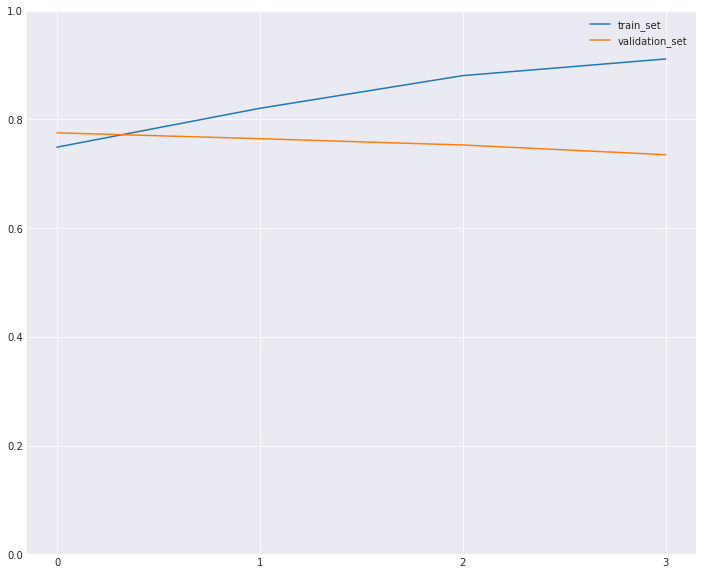

In [79]:
plt.figure(figsize=(12,10))
plt.plot(history.history["accuracy"],label="train_set")
plt.plot(history.history["val_accuracy"],label="validation_set")
plt.ylim(0,1)
plt.xticks([0,1,2,3])
plt.legend()
plt.show()

In [48]:
tokenizer_1.fit_on_texts(X_1)
X = tokenize_data(X_1,tokenizer_2,maxlen=None)

model = get_model_dl_classic(X,printing=False)

In [49]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =32, epochs = 1)

2500/2500 [==============================] - 32s 13ms/step - loss: 0.5381 - accuracy: 0.7267 - val_loss: 0.5310 - val_accuracy: 0.7401


# Plus de données

In [31]:
X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values

In [32]:
tokenizer_2.fit_on_texts(X)
X = tokenize_data(X,tokenizer_2,maxlen=None)

model = get_model_dl_classic(X,printing=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1310976   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,591,490
Trainable params: 2,591,490
Non-trainable params: 0
______________________________________________

In [33]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =32, epochs = 1)

32000/32000 [==============================] - 439s 14ms/step - loss: 0.4716 - accuracy: 0.7836 - val_loss: 0.4625 - val_accuracy: 0.7916


In [34]:
X = basic_clean(X_train,multithreading=True)

In [35]:
tokenizer_2.fit_on_texts(X)
X = tokenize_data(X,tokenizer_2,maxlen=None)

model = get_model_dl_classic(X,printing=False)

In [36]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =32, epochs = 1)

32000/32000 [==============================] - 484s 15ms/step - loss: 0.5077 - accuracy: 0.7535 - val_loss: 0.4964 - val_accuracy: 0.7619


# Glove embedding

In [66]:
# Paramètre des données glove
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200

https://www.kaggle.com/fullmetal26/glovetwitter27b100dtxt/download

In [67]:
%%time
import os
embeddings_index = {}
f = open(os.path.join('./data/glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.
CPU times: user 46.5 s, sys: 2.8 s, total: 49.3 s
Wall time: 1min 28s


In [73]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

def prepare_data_glove(X,Y,validation_data=True,printing=False):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    word_index = tokenizer.word_index
    if printing:
        print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    dic = {"good":0,"bad":1}
    labels = [dic[y] for y in Y]

    labels = to_categorical(np.asarray(labels))
    if printing:
        print('Shape of data tensor:', data.shape)
        print('Shape of label tensor:', labels.shape)
    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    if validation_data:
        nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
        x_train = data[:-nb_validation_samples]
        y_train = labels[:-nb_validation_samples]
        x_val = data[-nb_validation_samples:]
        y_val = labels[-nb_validation_samples:]
    else:
        x_train = data
        y_train = labels
        x_val = None
        y_val = None
        
    # Embedding
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        # vecteur d'un modèle glove pré-entrainé
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        
            embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    
    return x_train,y_train,x_val,y_val,embedding_layer

In [96]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Input,GlobalMaxPooling1D
from keras import Model

def get_model_glove(embedding_layer,printing=True):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
#     model.add(Conv1D(128, 5, activation='relu'))
#     model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    if printing:
        print(model.summary())
    return model

def get_model_LSTM_personal_embedding(embedding_layer,printing=True):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.1))
    model.add(LSTM(256))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    if printing:
        print(model.summary())
    return model

In [31]:
x_train,y_train,x_val,y_val,embedding_layer = prepare_data_glove(X_3,reduce_Y)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [34]:
model = get_model_glove(embedding_layer)
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          17896200  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               311424    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 18,336,010
Trainable params: 439,810
Non-trainable params: 17,896,200
____________________________________

In [32]:
model = get_model_glove(embedding_layer)
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          17896200  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 128)           82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [36]:
X = [cleanning_data(sentence) for sentence in X_train]

In [42]:
x_train,y_train,x_val,y_val,embedding_layer_2 = prepare_data_glove(X,y_train)

In [43]:
model = get_model_glove(embedding_layer_2)
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          101166000 
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 128)           128128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               311424    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 101,605,810
Trainable params: 439,810
Non-trainable params: 101,166,000
__________________________________

In [97]:
x_train,y_train,x_val,y_val,embedding_layer_3 = prepare_data_glove(stemming_data,y_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [98]:
model = get_model_glove(embedding_layer_3)
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          89587000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           128128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               311424    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 90,026,810
Trainable params: 439,810
Non-trainable params: 89,587,000
____________________________________

In [70]:
X = [cleanning_data(sentence) for sentence in X_train]

In [71]:
x_train,y_train,x_val,y_val,embedding_layer_4 = prepare_data_glove(X,y_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [74]:
model = get_model_LSTM_personal_embedding(embedding_layer_4)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=6, batch_size=512)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          101166000 
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 200)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 101,634,482
Trainable params: 468,482
Non-trainable params: 101,166,000
_________________________________________________________________
None
Epoch 1/6
2000/2000 [==============================] - 52s 26ms/step - loss: 0.4488 - accuracy:

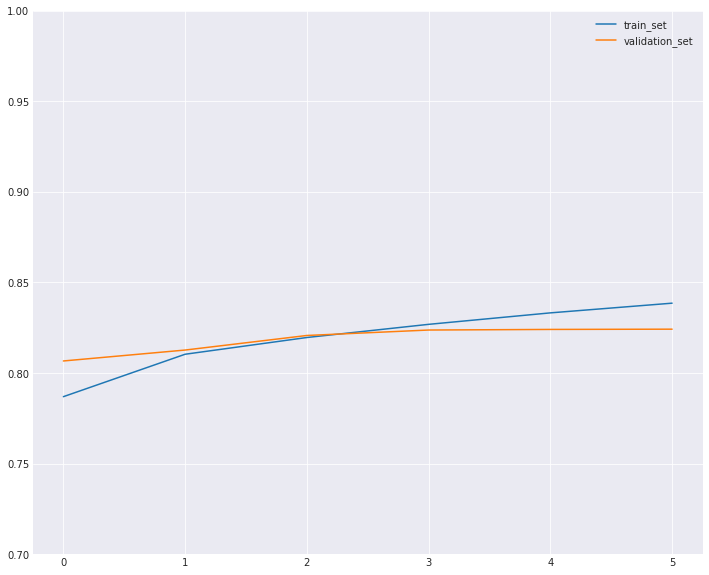

In [79]:
plt.figure(figsize=(12,10))
plt.plot(history.history["accuracy"],label="train_set")
plt.plot(history.history["val_accuracy"],label="validation_set")
plt.ylim(0.7,1)
plt.xticks([0,1,2,3,4,5])
plt.legend()
plt.show()

### Avec stemming

In [80]:
%%time
# Clean + stemming + stop_word
X_1 = basic_clean(X_train,multithreading=True,stemming=True)

CPU times: user 6min 59s, sys: 0 ns, total: 6min 59s
Wall time: 6min 58s


In [87]:
%%time
x_train,y_train,x_val,y_val,embedding_layer_5 = prepare_data_glove(X_1,y_train)

CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 33.2 s


In [88]:
model = get_model_LSTM_personal_embedding(embedding_layer_5)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=6, batch_size=512)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          108565000 
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 200)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 109,033,482
Trainable params: 468,482
Non-trainable params: 108,565,000
_________________________________________________________________
None
Epoch 1/6
2000/2000 [==============================] - 56s 28ms/step - loss: 0.4970 - accuracy:

## Word2Vec Embedding

In [19]:
import gensim

def create_layer_embedding_word_2_vec(X, W2V_SIZE = 300, W2V_WINDOW = 7, W2V_EPOCH = 32,
                                      W2V_MIN_COUNT = 10, SEQUENCE_LENGTH = 300, workers=32):
    
    documents = [_text.split() for _text in X]
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=workers)
    w2v_model.build_vocab(documents)
    
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    x_train = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=SEQUENCE_LENGTH)
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE,
                                           weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
    
    return x_train, embedding_layer_word_2_vec, tokenizer

In [95]:
%%time
x_train, embedding_layer_w2v, tokenizer = create_layer_embedding_word_2_vec(X_1)

CPU times: user 24min 10s, sys: 11.6 s, total: 24min 22s
Wall time: 8min 13s


In [99]:
Y = pd.get_dummies(y_train).values

In [100]:
model = get_model_LSTM_personal_embedding(embedding_layer_w2v)

history = model.fit(x_train, Y, validation_split=0.1 ,epochs=8, batch_size=1024)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          162847500 
_________________________________________________________________
dropout_14 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 163,418,382
Trainable params: 570,882
Non-trainable params: 162,847,500
_________________________________________________________________
None
Epoch 1/8
1125/1125 [==============================] - 91s 80ms/step - loss: 0.4961 - accuracy:

In [37]:
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

In [22]:
%%time
X = [cleanning_data(sentence) for sentence in X_train]

CPU times: user 50.8 s, sys: 0 ns, total: 50.8 s
Wall time: 50.8 s


In [36]:
%%time
test_X = [cleanning_data(sentence) for sentence in X_test]

CPU times: user 12.6 s, sys: 6.65 ms, total: 12.6 s
Wall time: 12.6 s


In [56]:
Y = pd.get_dummies(y_train).values
test_Y = pd.get_dummies(y_test).values

In [23]:
%%time
documents = [_text.split() for _text in X]

CPU times: user 2.89 s, sys: 192 ms, total: 3.08 s
Wall time: 3.08 s


In [25]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=32)

In [26]:
w2v_model.build_vocab(documents)

In [32]:
words = w2v_model.wv.index_to_key
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 36963


In [33]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 25min 37s, sys: 17.7 s, total: 25min 54s
Wall time: 4min 18s


(383102385, 499965504)

In [35]:
w2v_model.wv.most_similar("love")

[('luv', 0.6479347944259644),
 ('adore', 0.6370643973350525),
 ('loves', 0.6069856286048889),
 ('looove', 0.5996899008750916),
 ('loooove', 0.5979689955711365),
 ('loveee', 0.5730721950531006),
 ('loove', 0.5558979511260986),
 ('lovee', 0.546833336353302),
 ('loved', 0.5401460528373718),
 ('looooove', 0.5308914184570312)]

In [38]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 505830
CPU times: user 16.8 s, sys: 107 ms, total: 17 s
Wall time: 17 s


In [39]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_X), maxlen=SEQUENCE_LENGTH)

CPU times: user 24.3 s, sys: 439 ms, total: 24.7 s
Wall time: 24.7 s


In [45]:
%%time
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv.index_to_key:
        embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
print(embedding_matrix.shape)

(505830, 300)
CPU times: user 4min 11s, sys: 0 ns, total: 4min 11s
Wall time: 4min 11s


In [46]:
embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [61]:
model = Sequential()
model.add(embedding_layer_word_2_vec)
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          151749000 
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 152,319,882
Trainable params: 570,882
Non-trainable params: 151,749,000
_________________________________________________________________


In [62]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [63]:
model.fit(x_train, Y,batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.1)

Epoch 1/8
1125/1125 [==============================] - 94s 82ms/step - loss: 0.4633 - accuracy: 0.7809 - val_loss: 0.4234 - val_accuracy: 0.8033
Epoch 2/8
1125/1125 [==============================] - 95s 84ms/step - loss: 0.4196 - accuracy: 0.8062 - val_loss: 0.4021 - val_accuracy: 0.8160
Epoch 3/8
1125/1125 [==============================] - 90s 80ms/step - loss: 0.4027 - accuracy: 0.8157 - val_loss: 0.3911 - val_accuracy: 0.8209
Epoch 4/8
1125/1125 [==============================] - 90s 80ms/step - loss: 0.3930 - accuracy: 0.8212 - val_loss: 0.3837 - val_accuracy: 0.8264
Epoch 5/8
1125/1125 [==============================] - 91s 81ms/step - loss: 0.3861 - accuracy: 0.8251 - val_loss: 0.3781 - val_accuracy: 0.8287
Epoch 6/8
1125/1125 [==============================] - 91s 81ms/step - loss: 0.3799 - accuracy: 0.8284 - val_loss: 0.3762 - val_accuracy: 0.8313
Epoch 7/8
1125/1125 [==============================] - 91s 81ms/step - loss: 0.3732 - accuracy: 0.8322 - val_loss: 0.3721 - val_ac

In [64]:
score,acc = model.evaluate(x_test, test_Y, batch_size = BATCH_SIZE)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

313/313 [==============================] - 10s 30ms/step - loss: 0.3726 - accuracy: 0.8329
Score: 0.37
Validation Accuracy: 0.83


# Bert test

In [24]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [25]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [26]:
dic = {"good":0,"bad":1}
labels = [dic[y] for y in reduce_Y]

In [43]:
import random
random.seed(42)
c = list(zip(reduce_X,labels))
random.shuffle(c)
X_train_red,labels_red = zip(*c)

In [44]:
X_train_reduce = X_train_red[:10000]
X_test_reduce = X_train_red[10000:15000]

y_train_reduce = labels_red[:10000]
y_test_reduce = labels_red[10000:15000]

In [45]:
train = pd.DataFrame([X_train_reduce,y_train_reduce],index=["DATA_COLUMN","LABEL_COLUMN"]).T
test =  pd.DataFrame([X_test_reduce,y_test_reduce],index=["DATA_COLUMN","LABEL_COLUMN"]).T
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Pizza with my baby @TheWorldAndI,0
1,The food craving hole is long gone. Right now ...,1
2,@AshelyMonroe I miss you like fucking crazy! n...,1
3,My body hurts,1
4,@cheetah757 hey sis how are u..i texed u da ot...,1


In [46]:
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,@guidfletcher I know the answer,0
1,"At sea rocket bistro for grilled sardine, clam...",1
2,ahhhhh tired. Going to the doctor on Monday......,1
3,G'mornin Earth Lovers!,0
4,i miss peoplee come backkk. chrissy. bio is a...,1


In [34]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [47]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [48]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [49]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

bert_model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
626/626 [==============================] - 321s 488ms/step - loss: 0.3740 - accuracy: 0.8363 - val_loss: 0.4627 - val_accuracy: 0.8160
Epoch 2/2
626/626 [==============================] - 304s 486ms/step - loss: 0.1151 - accuracy: 0.9600 - val_loss: 0.7121 - val_accuracy: 0.8010


In [53]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']

In [55]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = bert_model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
lab = list(dic.keys())
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": \n", lab[label[i]])

This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good : 
 good
One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie : 
 bad


# Bert avec plus de données

In [56]:
X_train_reduce = X_train_red[:90000]
X_test_reduce = X_train_red[90000:]

y_train_reduce = labels_red[:90000]
y_test_reduce = labels_red[90000:]

In [60]:
train = pd.DataFrame([X_train_reduce,y_train_reduce],index=["DATA_COLUMN","LABEL_COLUMN"]).T
test =  pd.DataFrame([X_test_reduce,y_test_reduce],index=["DATA_COLUMN","LABEL_COLUMN"]).T

In [62]:
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
%%time
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

CPU times: user 42.6 s, sys: 0 ns, total: 42.6 s
Wall time: 42.5 s


In [63]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

bert_model.fit(train_data, epochs=1, validation_data=validation_data)

5626/5626 [==============================] - 2603s 460ms/step - loss: 0.3269 - accuracy: 0.8583 - val_loss: 0.3979 - val_accuracy: 0.8400


In [64]:
bert_model.save("./data/model/bert_model_train100000")

INFO:tensorflow:Assets written to: ./data/model/bert_model_train100000/assets


INFO:tensorflow:Assets written to: ./data/model/bert_model_train100000/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def predict_bert(model,document,labels):
    tf_batch = tokenizer(document, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    return label

# Embedding classique - LSTM

In [21]:
from keras.layers import Dropout
def get_basic_model(X,embed_dim = 128,lstm_out = 256,batch_size = 32,printing=True):
    model = Sequential()
    model.add(Embedding(10000, embed_dim,input_length = X.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_out))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    if printing:
        print(model.summary())
    return model

## Test 1.1

In [195]:
tokenizer_1.fit_on_texts(X_1)

In [196]:
X = tokenize_data(X_1,tokenizer_1,maxlen=None)

In [197]:
model = get_basic_model(X)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 30, 128)           1280000   
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 514       
Total params: 1,674,754
Trainable params: 1,674,754
Non-trainable params: 0
_________________________________________________________________
None


In [198]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 52s 21ms/step - loss: 0.5351 - accuracy: 0.7267 - val_loss: 0.5134 - val_accuracy: 0.7456


## Test 1.2

In [199]:
tokenizer_2.fit_on_texts(X_1)
X = tokenize_data(X_1,tokenizer_2,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 53s 21ms/step - loss: 0.5287 - accuracy: 0.7336 - val_loss: 0.5035 - val_accuracy: 0.7516


## Test 1.3

In [200]:
tokenizer_1.fit_on_texts(X_2)
X = tokenize_data(X_2,tokenizer_1,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 54s 21ms/step - loss: 0.4975 - accuracy: 0.7573 - val_loss: 0.4740 - val_accuracy: 0.7782


# Test 1.4

In [201]:
tokenizer_2.fit_on_texts(X_2)
X = tokenize_data(X_2,tokenizer_2,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 57s 22ms/step - loss: 0.4931 - accuracy: 0.7623 - val_loss: 0.4632 - val_accuracy: 0.7845


# Test 1.5

In [202]:
tokenizer_1.fit_on_texts(X_3)

X = tokenize_data(X_3,tokenizer_1,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 54s 21ms/step - loss: 0.4981 - accuracy: 0.7565 - val_loss: 0.4687 - val_accuracy: 0.7762


# Test 1.6

In [203]:
tokenizer_2.fit_on_texts(X_3)
X = tokenize_data(X_3,tokenizer_2,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 54s 21ms/step - loss: 0.4927 - accuracy: 0.7602 - val_loss: 0.4646 - val_accuracy: 0.7833


# Test 1.7

In [204]:
tokenizer_1.fit_on_texts(X_4)
X = tokenize_data(X_4,tokenizer_1,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 55s 22ms/step - loss: 0.4969 - accuracy: 0.7597 - val_loss: 0.4649 - val_accuracy: 0.7763


# Test 1.8

In [205]:
tokenizer_2.fit_on_texts(X_4)
X = tokenize_data(X_4,tokenizer_2,maxlen=None)

model = get_basic_model(X,printing=False)

trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

2500/2500 [==============================] - 55s 22ms/step - loss: 0.4881 - accuracy: 0.7644 - val_loss: 0.4581 - val_accuracy: 0.7835


>On remarque que le jeu de donnée qui semblent le plus performant est le jeu de données avec un simple clean regex mais perd en performance avec une lemmatization.

# Test 2

In [206]:
X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values
tokenizer = Tokenizer(num_words=10000,split=' ')

In [207]:
tokenizer.fit_on_texts(X)

In [208]:
X = tokenize_data(X,tokenizer,maxlen=None)
print(X.shape)

(1280000, 40)


In [209]:
model = get_basic_model(X)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 128)           1280000   
_________________________________________________________________
dropout_44 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 514       
Total params: 1,674,754
Trainable params: 1,674,754
Non-trainable params: 0
_________________________________________________________________
None


In [212]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =batch_size, epochs = 1)

32000/32000 [==============================] - 711s 22ms/step - loss: 0.4203 - accuracy: 0.8064 - val_loss: 0.3924 - val_accuracy: 0.8215


### Test_set

In [215]:
test_X = [cleanning_data(sentence) for sentence in X_test]
test_Y = pd.get_dummies(y_test).values

In [216]:
test_X = tokenize_data(test_X,tokenizer,maxlen=40)

In [217]:
score,acc = model.evaluate(test_X, test_Y, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

10000/10000 [==============================] - 82s 8ms/step - loss: 0.3935 - accuracy: 0.8217
Score: 0.39
Validation Accuracy: 0.82


In [220]:
predictions = model.predict(test_X)
predicted_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(test_Y,axis=1)

In [221]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,predicted_classes)
pd.DataFrame(cm,columns=["bad","good"],index=["bad","good"])

,bad,good
bad,131072,28928
good,28129,131871


# Optimisation model (fine tuning)

## LSTM classique

In [22]:
X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values
tokenizer = Tokenizer(num_words=10000,split=' ')

In [23]:
test_X = [cleanning_data(sentence) for sentence in X_test]
test_Y = pd.get_dummies(y_test).values

In [24]:
tokenizer.fit_on_texts(X)

In [25]:
tokenizer.fit_on_texts(X)
X = tokenize_data(X,tokenizer,maxlen=40)
print(X.shape)

(1280000, 40)


In [26]:
test_X = tokenize_data(test_X,tokenizer,maxlen=40)

In [27]:
test_X.shape

(320000, 40)

In [30]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([512,1028]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
HP_EMBEDDING_VOCAB = hp.HParam('embedding_vocab_size',hp.Discrete([2500,10000,25000]))
HP_EMBEDDING_DIM = hp.HParam('embedding_dim_pad',hp.Discrete([64,128,256]))

In [31]:
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('./logs/hparam_tuning_2').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_OPTIMIZER,HP_EMBEDDING_VOCAB,HP_EMBEDDING_DIM],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [34]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(hparams[HP_EMBEDDING_VOCAB], hparams[HP_EMBEDDING_DIM],input_length = 40),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation="softmax"),
    ])
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    model.fit(X, Y, epochs=1) 
    _, accuracy = model.evaluate(test_X, test_Y)
    return accuracy
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [35]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        for vocab_size in HP_EMBEDDING_VOCAB.domain.values:
            for dim_embed in HP_EMBEDDING_DIM.domain.values:
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_OPTIMIZER: optimizer,
                    HP_EMBEDDING_VOCAB:vocab_size,
                    HP_EMBEDDING_DIM:dim_embed,
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning_2/' + run_name, hparams)
                session_num += 1s
                

--- Starting trial: run-0
{'num_units': 512, 'optimizer': 'adam', 'embedding_vocab_size': 2500, 'embedding_dim_pad': 64}
10000/10000 [==============================] - 79s 8ms/step - loss: 0.4116 - accuracy: 0.8099
--- Starting trial: run-1
{'num_units': 512, 'optimizer': 'adam', 'embedding_vocab_size': 2500, 'embedding_dim_pad': 128}
10000/10000 [==============================] - 78s 8ms/step - loss: 0.4091 - accuracy: 0.8121
--- Starting trial: run-2
{'num_units': 512, 'optimizer': 'adam', 'embedding_vocab_size': 2500, 'embedding_dim_pad': 256}
10000/10000 [==============================] - 78s 8ms/step - loss: 0.4073 - accuracy: 0.8128
--- Starting trial: run-3
{'num_units': 512, 'optimizer': 'adam', 'embedding_vocab_size': 10000, 'embedding_dim_pad': 64}
10000/10000 [==============================] - 79s 8ms/step - loss: 0.3922 - accuracy: 0.8218
--- Starting trial: run-4
{'num_units': 512, 'optimizer': 'adam', 'embedding_vocab_size': 10000, 'embedding_dim_pad': 128}
10000/10000 [=

In [55]:
%load_ext tensorboard

In [56]:
%tensorboard --logdir logs/hparam_tuning_2 --host 0.0.0.0

In [105]:
!kill 6218

## Word2Vec - LSTM
### Création de la couche embedding word2vec et des données

In [20]:
import gensim

def create_layer_embedding_word_2_vec(X, W2V_SIZE = 300, W2V_WINDOW = 7, W2V_EPOCH = 32,
                                      W2V_MIN_COUNT = 10, SEQUENCE_LENGTH = 300, workers=32):
    
    documents = [_text.split() for _text in X]
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=workers)
    w2v_model.build_vocab(documents)
    
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE,
                                           weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
    
    return embedding_layer_word_2_vec

In [52]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64,128,256,400]))
HP_EPOCHS = hp.HParam("epoch",hp.Discrete([6,8]))

In [48]:
%%time
X = [cleanning_data(tweet) for tweet in X_train]

CPU times: user 50.2 s, sys: 0 ns, total: 50.2 s
Wall time: 50.1 s


In [49]:
%%time
embedding = create_layer_embedding_word_2_vec(X,W2V_SIZE=300,SEQUENCE_LENGTH=300)

CPU times: user 30min 40s, sys: 0 ns, total: 30min 40s
Wall time: 9min 18s


In [50]:
test_X = [cleanning_data(tweet) for tweet in X_test]
Y = pd.get_dummies(y_train).values
test_Y = pd.get_dummies(y_test).values

In [51]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
x_train = pad_sequences(tokenizer.texts_to_sequences(X),maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_X),maxlen=300)

CPU times: user 42.7 s, sys: 0 ns, total: 42.7 s
Wall time: 42.7 s


### Création des routines

In [53]:
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('./logs/hparam_tuning_w2v').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS,HP_EPOCHS],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [54]:
def train_test_model(hparams):
    model = Sequential()
    model.add(embedding)
    model.add(LSTM(hparams[HP_NUM_UNITS]))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    model.fit(x_train, Y, epochs=hparams[HP_EPOCHS], batch_size=512) 
    _, accuracy = model.evaluate(x_test, test_Y,batch_size=512)
    return accuracy
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [57]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for epoch in HP_EPOCHS.domain.values:
        hparams = {
            HP_NUM_UNITS: num_units,
            HP_EPOCHS: epoch,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning_w2v/' + run_name, hparams)
        session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning_w2v --host 0.0.0.0

# Résultat 

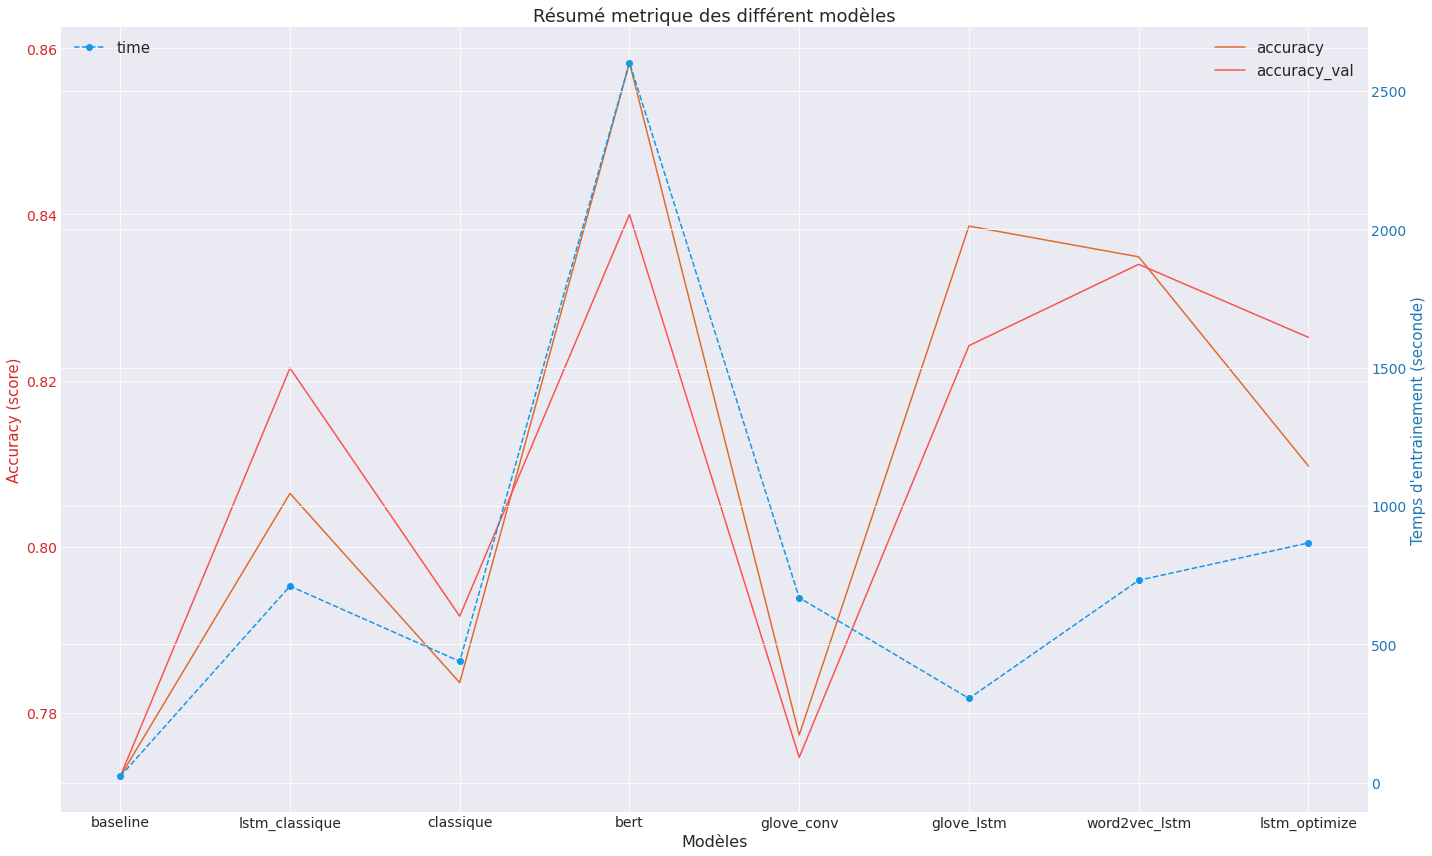

In [101]:
result_final = {
    "baseline":{"acc":0.7723,"val_acc":0.7723,"nb_data":1600000,"time":23},
    "lstm_classique":{"acc":0.8064,"val_acc":0.8215,"nb_data":1280000,"time":711},
    "classique_dl":{"acc":0.7836,"val_acc":0.7916,"nb_data":1280000,"time":439},
    "bert":{"acc":0.8583,"val_acc":0.8400,"nb_data":100000,"time":2603},
    "glove_conv":{"acc":0.7773,"val_acc":0.7746,"nb_data":1280000,"time":669},
    "glove_lstm":{"acc":0.8386,"val_acc":0.8242,"nb_data":1280000,"time":305},
    "word2vec_lstm":{"acc":0.8349,"val_acc":0.8340,"nb_data":1280000,"time":732},
    # pour optimize on à entrainé sur tout le jeu de données "acc" puis test sur le jeu de test "val_acc" 
    "lstm_classique_optimize":{"acc":0.8097,"val_acc":0.8252,"nb_data":1600000,"time":867},
    # A faire:
    "word2vec_lstm_optimize":{"acc":0.8349,"val_acc":0.8340,"nb_data":1600000,"time":732},
}

fig, ax1 = plt.subplots(figsize=(20,12))
ax1.set_xlabel("Modèles",fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.set_ylabel("Accuracy (score)",color='tab:red',fontsize=15)
ax1.plot([k for k in result_final.keys()],[v["acc"] for v in result_final.values()],label="accuracy",color="#E26A2C")
ax1.plot([k for k in result_final.keys()],[v["val_acc"] for v in result_final.values()],label="accuracy_val",color="#FF5151")
ax1.tick_params(axis='y', labelcolor='tab:red',labelsize=14)

ax2 = ax1.twinx()

ax2.plot([k for k in result_final.keys()],[v["time"] for v in result_final.values()],
         label="time",color="#1597E5",marker="o",ls="--")
ax2.set_ylabel('Temps d\'entrainement (seconde)', color='tab:blue',fontsize=15) 
ax2.tick_params(axis='y', labelcolor='tab:blue',labelsize=14)

plt.title("Résumé metrique des différent modèles",fontsize=18)
ax1.legend(fontsize=15)
ax2.legend(loc="upper left",fontsize=15)
fig.tight_layout()
plt.show()

# Export du modèle final 

In [16]:
import joblib # le tous ou alors save direct avec tensorflow et juste save avec joblib le cleanner_data

In [17]:
X_train = df_nlp["text"]
y_train = df_nlp["sentiment"]

In [18]:
# on retire les données de test :
new_size=4000
size=new_size//2

pos_X = []
i = 1500000
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(i)
    i+=1

i=700000
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(i)
    i+=1
id_pos_test_set = pos_X
id_pos_test_set.extend(neg_X)

In [19]:
X_train.drop(id_pos_test_set,axis=0,inplace=True)
y_train.drop(id_pos_test_set,axis=0,inplace=True)

In [27]:
X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values
tokenizer = Tokenizer(num_words=10000,split=' ')

In [28]:
tokenizer.fit_on_texts(X)
X = tokenize_data(X,tokenizer,maxlen=40)
print(X.shape)

(1596000, 40)


In [29]:
best_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 128,input_length = 40),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(1028),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation="softmax"),
])

best_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [31]:
best_model.fit(X,Y,epochs=1)

49875/49875 [==============================] - 1137s 23ms/step - loss: 0.4100 - accuracy: 0.8121


### Test 

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score
def benchmark(y_pred,y_true):
    print("accuracy score :",accuracy_score(y_true,y_pred))
    print(classification_report(y_true,y_pred))
    return pd.DataFrame(confusion_matrix(y_true,y_pred),columns=["good","bad"],index=["good","bad"])

def prepared_data(list_tweet,tokenizer):
    data_clean = [cleanning_data(tweet) for tweet in list_tweet]
    return tokenize_data(data_clean,tokenizer,maxlen=40)

In [37]:
X_test = prepared_data(df_nlp["text"].loc[id_pos_test_set].tolist(),tokenizer)
y_test = df_nlp["sentiment"].loc[id_pos_test_set].tolist()

In [45]:
predictions = best_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
test_Y = pd.get_dummies(y_test).values
y_true = np.argmax(test_Y,axis=1)

In [47]:
dic={0:"good",1:"bad"}
y_true = [dic[y] for y in y_true]
y_pred = [dic[y] for y in y_pred]

In [48]:
benchmark(y_pred,y_true)

accuracy score : 0.836
              precision    recall  f1-score   support

         bad       0.84      0.84      0.84      2000
        good       0.84      0.84      0.84      2000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



,good,bad
good,1673,327
bad,329,1671


## Pipeline

In [15]:
import modelisation_avanced as md_avanced

In [16]:
pipeline = md_avanced.create_pipeline()

In [21]:
X_clean= md_avanced.preprocessed_data(X_train)

In [23]:
pipeline.fit(X_clean,y_train)

49875/49875 [==============================] - 1015s 20ms/step - loss: 0.4091 - accuracy: 0.8126


Pipeline(steps=[('tokenizer', TokenizerTransformer()),
                ('padder', PadSequencesTransformer(maxlen=40)),
                ('model',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe2707d8160>)])

In [24]:
X_test = md_avanced.preprocessed_data(df_nlp["text"].loc[id_pos_test_set].tolist())
y_test = df_nlp["sentiment"].loc[id_pos_test_set].tolist()

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score
def benchmark(y_pred,y_true):
    print("accuracy score :",accuracy_score(y_true,y_pred))
    print(classification_report(y_true,y_pred))
    return pd.DataFrame(confusion_matrix(y_true,y_pred),columns=["good","bad"],index=["good","bad"])

In [26]:
y_pred = pipeline.predict(X_test)

In [27]:
benchmark(y_pred,y_test)

accuracy score : 0.83375
              precision    recall  f1-score   support

         bad       0.83      0.85      0.84      2000
        good       0.84      0.82      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



,good,bad
good,1692,308
bad,357,1643


### Sauvegarde de la méthode de clean, du tokenizer et du modèle entrainé 

In [28]:
md_avanced.save_pipeline_keras(pipeline,path_to_model_data="./data/model")